<a href="https://colab.research.google.com/github/Beitner/Computer-vision---Cell-Counting/blob/main/Cell%20Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell Counting using computer vision

In this nootbook we will try to train a network in order to count cells given a photo.

We will do as follow:

1) Read the data (process the outputs) and split it to train
and test

2) Prepare the labels

3) Define the network

4) Train the network

In [97]:
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import cv2 as cv
import torch.nn.functional as F
import random
import operator
from itertools import tee
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary
import copy
from PIL import Image, ImageOps
from torchvision import datasets, models, transforms

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import copy
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn
%matplotlib inline
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, Dataset
import torchvision
import torchvision.models as models
import os
import time
import copy
from PIL import Image, ImageOps
from torchvision import datasets, models, transforms

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
PATH1 = r'/content/drive/MyDrive/Colab Notebooks/images1/train/'
PATH2 = r'/content/drive/MyDrive/Colab Notebooks/labels1/train/'


PATH3 = r'/content/drive/MyDrive/Colab Notebooks/images1/val/'
PATH4 = r'/content/drive/MyDrive/Colab Notebooks/labels1/val/'

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

****

##Create dataloaders##

In [29]:
class Cellsphoto(Dataset):
    def __init__(self, img_dir1,img_dir2, transform_high=None, transform_low=None):
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform_high = transform_high
        self.transform_low = transform_low
        self.img_fnames1 = sorted( filter( lambda x: os.path.isfile(os.path.join(img_dir1, x)),os.listdir(img_dir1) ) )
        self.img_fnames2 = sorted( filter( lambda x: os.path.isfile(os.path.join(img_dir2, x)),os.listdir(img_dir2) ) )
    def __len__(self):
        return len(self.img_fnames1)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.img_dir1, self.img_fnames1[idx])
        img_path2 = os.path.join(self.img_dir2, self.img_fnames2[idx])
        image1 = read_image(img_path1)
        image2 = read_image(img_path2)
        if self.transform_high:
            image_high = self.transform_high(image1)
        if self.transform_low:
            image_low = self.transform_low(image2)
        return image_high, image_low

In [30]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir1,img_dir2, transform_high=None, transform_low=None):
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform_high = transform_high
        self.transform_low = transform_low
        self.img_fnames1 = sorted( filter( lambda x: os.path.isfile(os.path.join(img_dir1, x)),os.listdir(img_dir1) ) )
        self.img_fnames2 = sorted( filter( lambda x: os.path.isfile(os.path.join(img_dir2, x)),os.listdir(img_dir2) ) )
    def __len__(self):
        return len(self.img_fnames1)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.img_dir1, self.img_fnames1[idx])
        img_path2 = os.path.join(self.img_dir2, self.img_fnames2[idx])
        image1 = read_image(img_path1)
        image2 = read_image(img_path2)
        if self.transform_high:
            image_high = self.transform_high(image1)
        if self.transform_low:
            image_low = self.transform_low(image2)
            image_low = np.sum(np.asarray(image_low)>0)
        return image_high, image_low

In [31]:
data_transforms = {
    'HIGH': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Grayscale(),

        

    ]),
    'LOW': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Grayscale(),


    ]),
    'Normal': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ]),
}

In [32]:
ds_photos = Cellsphoto(PATH1,PATH2,transform_high=data_transforms['Normal'],transform_low=data_transforms['Normal'])
ds_train  = CustomImageDataset(PATH1,PATH2,transform_high=data_transforms['HIGH'],transform_low=data_transforms['LOW'])
ds_val    = CustomImageDataset(PATH3,PATH4,transform_high=data_transforms['HIGH'],transform_low=data_transforms['LOW'])


In [33]:
for i in range (5):
  print(ds_val.img_fnames2[i],ds_val.img_fnames2[i])

001dots.png 001dots.png
002dots.png 002dots.png
003dots.png 003dots.png
004dots.png 004dots.png
005dots.png 005dots.png


In [34]:
temp  = (ds_photos[5][0])
temp1 = (ds_photos[5][1])

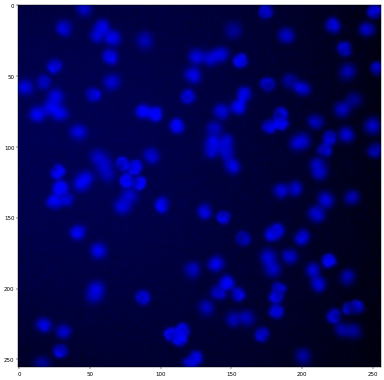

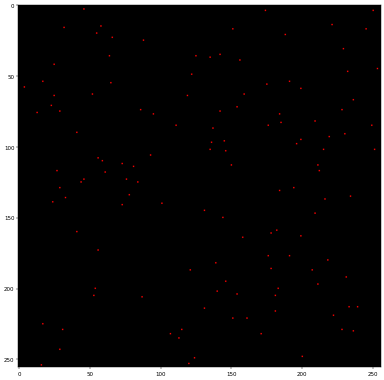

In [35]:
plt.figure(figsize=(12,12),dpi=40)
plt.imshow(np.transpose(temp,(1, 2, 0)))

plt.figure(figsize=(12,12),dpi=40)
plt.imshow(np.transpose(temp1,(1, 2, 0)))

In [36]:
dataloaders = {
    'train': torch.utils.data.DataLoader(ds_train, batch_size=1,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(ds_val, batch_size=1,
                                          shuffle=False, num_workers=2),

  }

image_datasets =dict()
image_datasets['train']=ds_train
image_datasets['val']=ds_val

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 160, 'val': 40}


## Define the network

In [45]:
class Net1(nn.Module):   
    def __init__(self):
        super(Net1, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 64 * 64, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_list = [] #For printing the plot of the loss and accuracy
    train_acc_list = []

    val_loss_list = []
    val_acc_list = []
    results=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            

            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device, torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    if (phase == 'val') and (epoch==num_epochs-1):
                      results.append(outputs)
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = 5 / dataset_sizes[phase]

            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_acc)
            else:
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_acc)


            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'{phase} Loss: {epoch_loss:.4f} ')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    


    time_elapsed = time.time() - since
    # print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    
    return model,results, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [87]:
model=Net1().to(device)

# criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
	# defining the loss function
criterion = torch.nn.MSELoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(summary(model, (1, 256, 256)))
num_epochs = 15

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 256, 256]              40
       BatchNorm2d-2          [-1, 4, 256, 256]               8
              ReLU-3          [-1, 4, 256, 256]               0
         MaxPool2d-4          [-1, 4, 128, 128]               0
            Conv2d-5          [-1, 4, 128, 128]             148
       BatchNorm2d-6          [-1, 4, 128, 128]               8
              ReLU-7          [-1, 4, 128, 128]               0
         MaxPool2d-8            [-1, 4, 64, 64]               0
            Linear-9                    [-1, 1]          16,385
Total params: 16,589
Trainable params: 16,589
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 8.13
Params size (MB): 0.06
Estimated Total Size (MB): 8.44
---------------------------------------------

## Training the model

In [88]:
trained_model,results1, train_loss, val_loss, train_acc, val_acc = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 4516.7537 
val Loss: 316.4308 

Epoch 1/14
----------
train Loss: 1658.5516 
val Loss: 162.0074 

Epoch 2/14
----------
train Loss: 953.3940 
val Loss: 372.3663 

Epoch 3/14
----------
train Loss: 539.8245 
val Loss: 577.0130 

Epoch 4/14
----------
train Loss: 242.9710 
val Loss: 329.3181 

Epoch 5/14
----------
train Loss: 90.6212 
val Loss: 290.3780 

Epoch 6/14
----------
train Loss: 37.2861 
val Loss: 457.3776 

Epoch 7/14
----------
train Loss: 10.1906 
val Loss: 603.9561 

Epoch 8/14
----------
train Loss: 8.1284 
val Loss: 244.9627 

Epoch 9/14
----------
train Loss: 7.2736 
val Loss: 245.9723 

Epoch 10/14
----------
train Loss: 6.2787 
val Loss: 244.1410 

Epoch 11/14
----------
train Loss: 5.5049 
val Loss: 541.0584 

Epoch 12/14
----------
train Loss: 4.6902 
val Loss: 243.0828 

Epoch 13/14
----------
train Loss: 3.9253 
val Loss: 803.7104 

Epoch 14/14
----------
train Loss: 3.2064 
val Loss: 256.6522 



In [92]:
pred=np.zeros(len(results1))
for i,item in enumerate((results1)):
  temp=(item[0][0])
  pred[i]=(temp.numpy())


In [95]:
y_true =np.zeros(len(results1))
for i in range(len(results1)):
  y_true[i]=(ds_val[i][1])



*************

## Results

In [96]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, pred)
print("AVG MSE:",mse/len(results1))

AVG MSE: 6.416305181969911
